In [1]:
import pandas as pd
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torchvision import models
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from typing_extensions import dataclass_transform
import random

torch.manual_seed(42)
np.random.seed(42)

In [2]:
class SkinData:
  def __init__(self, root, transform = True, train = True):
      if train:
        data_folder = 'balanced_dataset/'

      else:
        data_folder = 'Validation_Image/'

      data_dirs = os.listdir(os.path.join(root,data_folder))
      self.data_files = []
      self.labels = []
      label = 0
      for dir in data_dirs:
        path_name = os.path.join(root,data_folder,dir)
        data_samples = [os.path.join(path_name, fname) for fname in os.listdir(path_name)]
        label_samples = label * np.ones(len(data_samples))
        print(dir)
        print(len(label_samples))
        self.data_files.extend(data_samples)
        self.labels.extend(label_samples)
        self.transform = transform

        label += 1

  def __len__(self):
    return len(self.data_files)

  def __getitem__(self, index):
    new_width = 256
    new_height = 256
    data_file = self.data_files[index]
    image = np.array(cv2.imread(data_file))
    label = np.array(self.labels[index])

    data_sample = cv2.resize(image, (new_width, new_height))
    resize_data = np.array(data_sample)

    if self.transform:
      data_sample = torch.from_numpy(data_sample)
      lable = torch.from_numpy(label)

    data_point = {'data_sample': data_sample, 'lable':lable}

    return data_point

In [3]:
root = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer'
dataset = SkinData(root, transform=True, train= True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loder = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loder = DataLoader(test_dataset, batch_size=8, shuffle=False)

test_dataset = SkinData(root, transform=True, train = False)

dataloader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=8, shuffle=False)
dataloader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)

akiec
1244
bcc
1464
bkl
1044
df
1308
mel
1057
nv
1302
vasc
1350
akiec
16
bcc
26
bkl
55
df
6
mel
56
nv
335
vasc
7


In [4]:
len(train_dataset)

7015

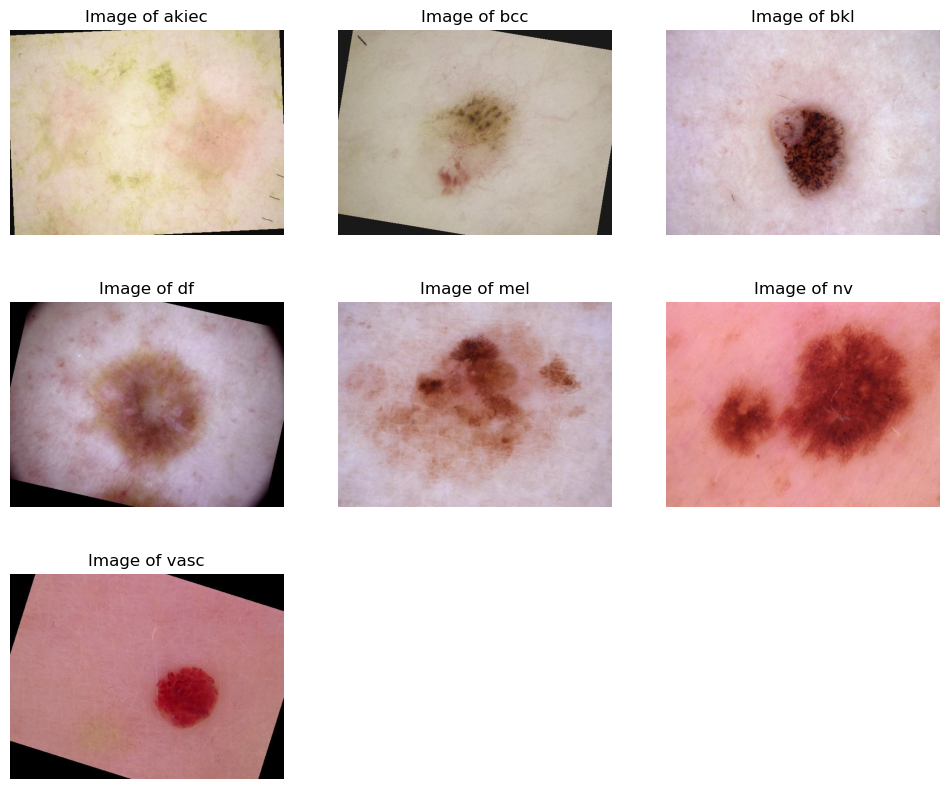

In [5]:
# Data Visualization
# Define the directory path for the training images
train_images_dir = r"C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Balanced_dataset"

top_n = 20  # Variable for top-n random images to select from.
image_sample = []  # List containing array of images.
image_sample_category = []  # List containing image type

# Make sure train_images_dir is correctly defined before this loop
for sub_dir in os.scandir(train_images_dir):
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = []  # List of top n images from current sub-dir.

    # Ensure we handle cases where there are fewer than top_n images
    num_images = min(len(images_paths), top_n)

    # Appending up to top_n images from the current sub-dir
    for image_path in images_paths[:num_images]:
        current_dir_img_paths.append(image_path)

    # Select a random image from the current directory
    if current_dir_img_paths:
        selected_image = random.choice(current_dir_img_paths)  # Selecting random image from the list
        image = cv2.imread(selected_image)  # Reading the image

        if image is not None:
            image = image[:, :, ::-1]  # Converting BGR to RGB
            image_sample_category.append(sub_dir.name)  # Append image category (cancer type)
            image_sample.append(image)  # Append the image array to the list
        else:
            print(f"Warning: Could not read image {selected_image}")
    else:
        print(f"No images found in directory {sub_dir.name}")

# Plotting the selected random images
plt.figure(figsize=(12, 10))
for num in range(len(image_sample)):
    plt.subplot(3, 3, num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}")
    plt.imshow(image_sample[num])

plt.show()

tensor(0., dtype=torch.float64)


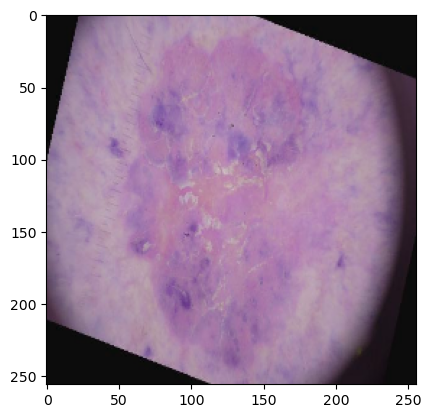

In [8]:
plt.imshow(train_dataset[1001]['data_sample'])
print(train_dataset[1001]['lable'])

In [10]:
train_dataset[1000]['data_sample'].shape

torch.Size([256, 256, 3])

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class ConvNeXtSkinCancer(nn.Module):
    def __init__(self, num_classes=7):
        super(ConvNeXtSkinCancer, self).__init__()
        self.convnext = models.convnext_base(pretrained=True)
        
        # Freeze early layers
        for param in list(self.convnext.parameters())[:-30]:
            param.requires_grad = False
        
        num_features = self.convnext.classifier[2].in_features
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
        self.convnext.classifier[2] = self.classifier
    
    def forward(self, x):
        return self.convnext(x)

# Example usage
# model = ConvNeXtSkinCancer(num_classes=7)
# print(model)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
net = ConvNeXtSkinCancer().to(device)

c:\Users\vindu\anaconda\envs\my\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vindu\anaconda\envs\my\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
print(torch.cuda.get_device_name(0))  # To check your GPU device name
print(torch.cuda.is_available())  # To confirm GPU is available

NVIDIA GeForce RTX 3050 Laptop GPU
True


In [15]:
import torch.optim as optim
# Print the network architecture
print(net)
# Optimizer: Adamax
optimizer = optim.Adamax(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Loss function
criterion = nn.CrossEntropyLoss()

ConvNeXtSkinCancer(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (

In [16]:
len(dataloader_train)

439

In [17]:
# Lists to store average losses and accuracies per epoch
avg_train_loss_list = []
avg_val_loss_list = []
train_acc_list = []
val_acc_list = []

# Define the directory to save/load models
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\Convnext'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
def load_checkpoint(model, optimizer, filename='latest_checkpoint.pth'):
    if os.path.exists(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch")
        start_epoch = 0  # Start from scratch if no checkpoint
    return start_epoch

# Load checkpoint if exists
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
start_epoch = load_checkpoint(net, optimizer,filename=checkpoint_path)

# Training Loop
for epoch in range(start_epoch,start_epoch+20):  # Now starts from the saved epoch
    accuracy = 0
    val_accuracy = 0
    running_loss = 0.0
    val_running_loss = 0.0
    num_batches_train = len(dataloader_train)
    num_batches_val = len(dataloader_val)

    # Training loop
    for i, data in enumerate(dataloader_train, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        loss = criterion(prediction, encoded_labels.float())
        running_loss += loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        accuracy += sum(predicted_class == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print('epoch:', epoch, 'loss:', loss.item())

    avg_train_loss = running_loss / num_batches_train
    avg_train_loss_list.append(avg_train_loss)

    # Validation loop
    for i, data in enumerate(dataloader_val, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        val_loss = criterion(prediction, encoded_labels.float())
        val_running_loss += val_loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        val_accuracy += sum(predicted_class == labels)

    avg_val_loss = val_running_loss / num_batches_val
    avg_val_loss_list.append(avg_val_loss)

    print(f'Epoch {epoch}: Train Accuracy: {accuracy/train_dataset.__len__()*100:.2f}%, '
          f'Validation Accuracy: {val_accuracy/val_dataset.__len__()*100:.2f}%')

    accuracy = accuracy.cpu().numpy()
    train_acc_list.append(accuracy / train_dataset.__len__() * 100)
    val_accuracy = val_accuracy.cpu().numpy()
    val_acc_list.append(val_accuracy / val_dataset.__len__() * 100)

    scheduler.step()

    # Save model checkpoint after each epoch
    torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss.item(),
}, os.path.join(save_dir, 'latest_checkpoint.pth'), _use_new_zipfile_serialization=False)


    print(f'Model saved after epoch {epoch}')
    print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

    # After each epoch, save metrics to a CSV file
    metrics_df = pd.DataFrame({
        'Epoch': [epoch],
        'Train Accuracy': [train_acc_list[-1]],
        'Validation Accuracy': [val_acc_list[-1]],
        'Average Train Loss': [avg_train_loss],
        'Average Validation Loss': [avg_val_loss]
    })

    metrics_df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), mode='a', index=False, header=not os.path.exists(os.path.join(save_dir, 'training_metrics.csv')))
    print("Epoch metrics saved to training_metrics.csv")



No checkpoint found at 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\Convnext\latest_checkpoint.pth', starting from scratch
epoch: 0 loss: 2.191831588745117
epoch: 0 loss: 1.9449872970581055
epoch: 0 loss: 1.7880345582962036
epoch: 0 loss: 1.696832537651062
epoch: 0 loss: 1.6284797191619873
epoch: 0 loss: 1.9257748126983643
epoch: 0 loss: 1.6344563961029053
epoch: 0 loss: 1.4268262386322021
epoch: 0 loss: 1.717555284500122
Epoch 0: Train Accuracy: 32.63%, Validation Accuracy: 38.43%
Model saved after epoch 0
Average Train Loss: 1.6979, Average Validation Loss: 1.5631
Epoch metrics saved to training_metrics.csv
epoch: 1 loss: 1.6054794788360596
epoch: 1 loss: 1.3845616579055786
epoch: 1 loss: 1.3815492391586304
epoch: 1 loss: 1.3179446458816528
epoch: 1 loss: 1.4415603876113892
epoch: 1 loss: 1.4819674491882324
epoch: 1 loss: 1.444624423980713
epoch: 1 loss: 1.4169095754623413
epoch: 1 loss: 1.3311913013458252
Epoch 1: Train Accuracy: 43.82%, Validation Accu

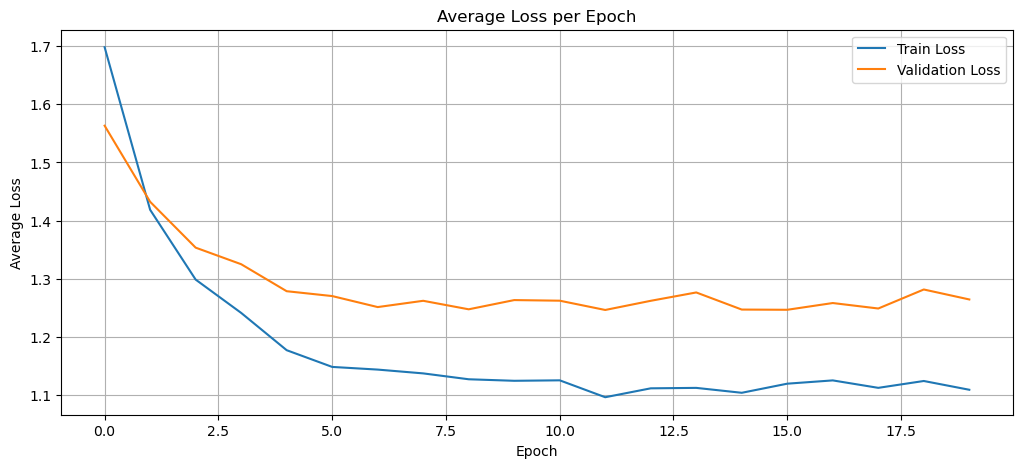

In [18]:
# Path to the CSV file
csv_file_path = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\Convnext\training_metrics.csv'

# Load the metrics from the CSV file
metrics_df = pd.read_csv(csv_file_path)

# Plot Average Losses
plt.figure(figsize=(27, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(metrics_df['Epoch'], metrics_df['Average Train Loss'], label='Train Loss')
plt.plot(metrics_df['Epoch'], metrics_df['Average Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.legend()
plt.grid(True)

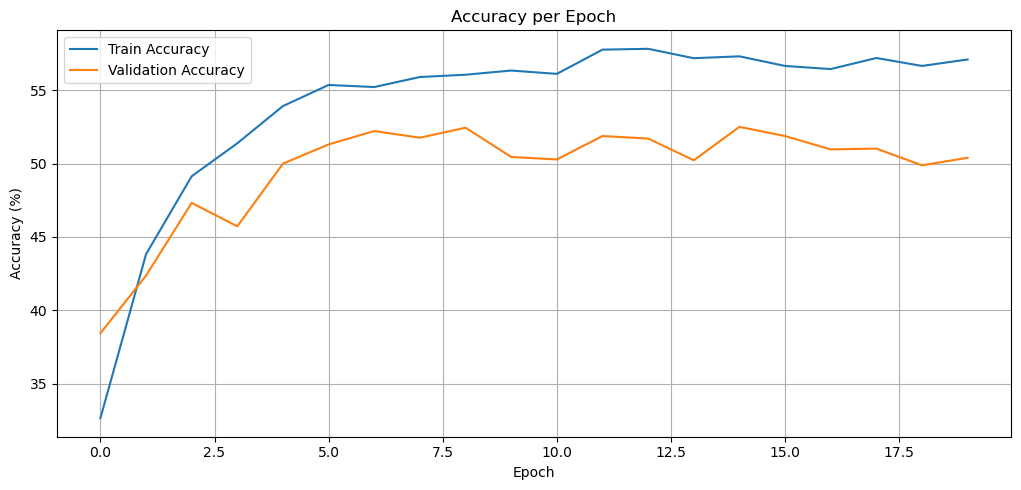

In [19]:
# Plot Accuracies
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Epoch'], metrics_df['Train Accuracy'], label='Train Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()